<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CS4740 Labs
##Week 4 - Convolutional Neural Networks

In this lab we will extend the classifier we have seen previously, to CIFAR10, a more challenging dataset of real (although very low-res) images. The dataset is split into ten classes (see below) and there is significant variability within each class.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1bn4UqHwT0v7Twk01KS9d_jVlOQpeMaNc'/>
<figcaption>CIFAR10 images</figcaption></center>
</figure>

To classify this dataset correctly we will need to upgrade our network to use convolutional layers. And because convolutions are very computationally demanding, we will see how to offload some of those computations to the GPU, dramatically reducing training times. 

## Section 1 - loading and exploring the dataset

First, let us load up the CIFAR10 dataset, for both training and testing.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

train_dataset = torchvision.datasets.CIFAR10('.', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.CIFAR10('.', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Let's examine one of the training datapoints:

torch.Size([3, 32, 32])
airplane


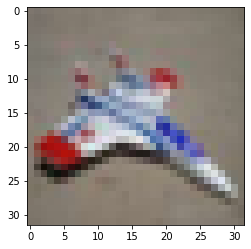

In [45]:
img, target = train_dataset[30]
print(img.shape)
plt.imshow(img.permute([1,2,0]))
print(train_dataset.classes[target])

The images are 32 by 32 and contain 3 color channels which is what we would expect for color images. This is very low res, however if a human is able to correctly classify these images, we should be able to program a neural network. We will be using a convolutional neural network architecture for this task, but first, let us understand how pytorch performs convolutions. 

We define a convolutional layer with the Conv2d class. The constructor takes the input and output number of channels as well as the size of the convolution kernel. Consider the following convolution layer:

In [19]:
conv = nn.Conv2d(3, 16, 5)

This layer is applied on tensors with 3 channels, and outputs a tensor with 16 channels. The size of the kernel is 5x5. 

0
torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 28, 28])
airplane


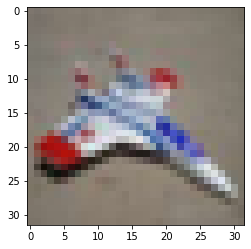

In [35]:
img, target = train_dataset[30]
plt.imshow(img.permute([1,2,0]))
print(target)

img = img[None,:,:,:]
print(img.shape)
out = conv(img)
print(out.shape)
print(train_dataset.classes[target])

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 256, 5)
        self.conv4 = nn.Conv2d(256, 128, 1)
        self.conv5 = nn.Conv2d(128, 10, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x.view(-1,10)

convnet = ConvNet()

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1000, shuffle=True)

In [5]:
x,t = next(iter(train_loader))
# x,t=x.cuda(),t.cuda()
convnet(x).shape

torch.Size([64, 10])

In [11]:
convnet.

ConvNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [6]:
def train(net,dataloader, optimizer,loss_fun):
  net.train()
  for x, t in dataloader:
    # x = x.cuda()
    # t = t.cuda()
    optimizer.zero_grad()
    L = loss_fun(net(x), t)
    L.backward()
    optimizer.step()

def test(net,dataloader,loss_fun):
  net.eval()
  total_L = 0
  correct = 0
  with torch.no_grad():
    for x, t in dataloader:
    #   x = x.cuda()
    #   t = t.cuda()
      out = net(x)
      total_L += loss_fun(out, t)
      _,pred = out.max(dim=1)     # this counts how many we got right
      correct += (pred==t).sum() 
  total_L /= len(dataloader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    total_L, correct, len(dataloader.dataset),
    100. * correct / len(dataloader.dataset)))

In [7]:
optim_SGD = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.5)

for e in range(100):
  print(f"Epoch: {e+1}/10. Training ...")
  train(convnet, train_loader, optim_SGD, nn.CrossEntropyLoss())
  print("Testing ...")
  test(convnet, test_loader,  nn.CrossEntropyLoss(reduction='sum'))  

Epoch: 1/10. Training ...
Testing ...

Test set: Avg. loss: 2.0482, Accuracy: 2544/10000 (25%)

Epoch: 2/10. Training ...


KeyboardInterrupt: ignored